In [1]:
# Import all required libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

In [2]:
# Data preprocessing
# Load and clean raw data
df = pd.read_csv("credit_train.csv")
df = df.drop(columns=['Loan ID', 'Customer ID'])

# Convert data types
cat_cols = ['Loan Status', 'Term', 'Years in current job', 'Home Ownership', 'Purpose']
for col in cat_cols:
    df[col] = df[col].astype('category')

int_cols = ['Credit Score', 'Number of Open Accounts', 'Number of Credit Problems', 
            'Bankruptcies', 'Tax Liens']
for col in int_cols:
    df[col] = pd.to_numeric(df[col], errors='coerce').astype('Int64')

float_cols = ['Current Loan Amount', 'Annual Income', 'Monthly Debt', 
              'Years of Credit History', 'Months since last delinquent',
              'Current Credit Balance', 'Maximum Open Credit']
for col in float_cols:
    df[col] = pd.to_numeric(df[col], errors='coerce')

# Create target variable
df['Loan Status_n'] = df['Loan Status'].map({'Fully Paid': 0, 'Charged Off': 1})
df = df.drop(columns=['Loan Status'])

# Feature engineering
df['Has_Delinquency'] = df['Months since last delinquent'].isna().astype(int)
df['Months since last delinquent'] = df['Months since last delinquent'].apply(
    lambda x: 0 if pd.isna(x) else x + 1)

# Handle missing values
for col in df.select_dtypes(include=['float64', 'int64', 'Int64']).columns:
    if col != 'Months since last delinquent':
        df[col] = df[col].fillna(df[col].median())

for col in df.select_dtypes(include='category').columns:
    df[col] = df[col].fillna(df[col].mode()[0])

# Save processed data
df.to_csv("credit_processed.csv", index=False)
print("Data preprocessing completed. Saved to credit_processed.csv")

Data preprocessing completed. Saved to credit_processed.csv


In [3]:
# Load processed data and verify
df = pd.read_csv("credit_processed.csv")
print(f"Processed data shape: {df.shape}")
print("\nTarget distribution:")
print(df['Loan Status_n'].value_counts(normalize=True))

Processed data shape: (100514, 18)

Target distribution:
Loan Status_n
0    0.774768
1    0.225232
Name: proportion, dtype: float64


In [4]:
# Prepare data for modeling
X = df.drop(columns=['Loan Status_n'])
y = df['Loan Status_n']

# Split data with stratification
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=42,
    stratify=y
)
print(f"\nTraining set: {X_train.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")


Training set: 80411 samples
Test set: 20103 samples


In [5]:
# Set up preprocessing pipeline
# Identify feature types
categorical_cols = X.select_dtypes(include=['object', 'category']).columns.tolist()
numerical_cols = X.select_dtypes(include=['int64', 'float64', 'Int64']).columns.tolist()

print("Categorical features:", categorical_cols)
print("Numerical features:", numerical_cols)

# Create column transformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', 'passthrough', numerical_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
    ])

Categorical features: ['Term', 'Years in current job', 'Home Ownership', 'Purpose']
Numerical features: ['Current Loan Amount', 'Credit Score', 'Annual Income', 'Monthly Debt', 'Years of Credit History', 'Months since last delinquent', 'Number of Open Accounts', 'Number of Credit Problems', 'Current Credit Balance', 'Maximum Open Credit', 'Bankruptcies', 'Tax Liens', 'Has_Delinquency']


In [6]:
# Build and train Random Forest model
rf_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(
        random_state=42,
        n_estimators=150,
        class_weight='balanced',
        max_depth=10,
        n_jobs=-1
    ))
])

# Train model
rf_pipeline.fit(X_train, y_train)
print("Random Forest model trained successfully")

Random Forest model trained successfully



Model Performance:
Accuracy: 0.7111
AUC-ROC: 0.7543

Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.74      0.80     15575
           1       0.40      0.60      0.48      4528

    accuracy                           0.71     20103
   macro avg       0.63      0.67      0.64     20103
weighted avg       0.76      0.71      0.73     20103



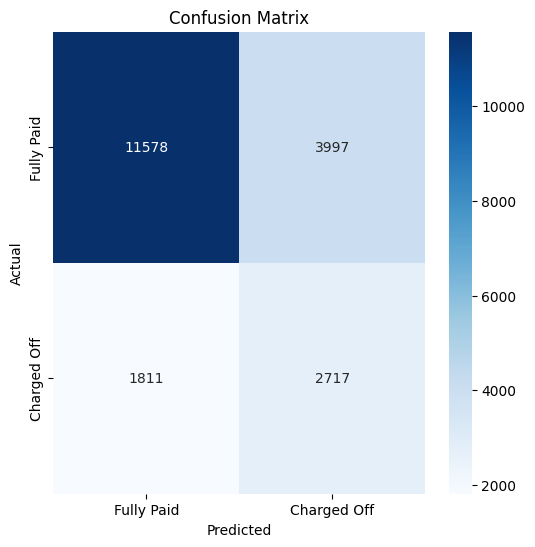

In [7]:
# Model evaluation
# Generate predictions
y_pred = rf_pipeline.predict(X_test)
y_proba = rf_pipeline.predict_proba(X_test)[:, 1]

# Calculate metrics
print("\nModel Performance:")
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print(f"AUC-ROC: {roc_auc_score(y_test, y_proba):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Confusion matrix
plt.figure(figsize=(6, 6))
sns.heatmap(confusion_matrix(y_test, y_pred), 
            annot=True, fmt='d', cmap='Blues',
            xticklabels=['Fully Paid', 'Charged Off'],
            yticklabels=['Fully Paid', 'Charged Off'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

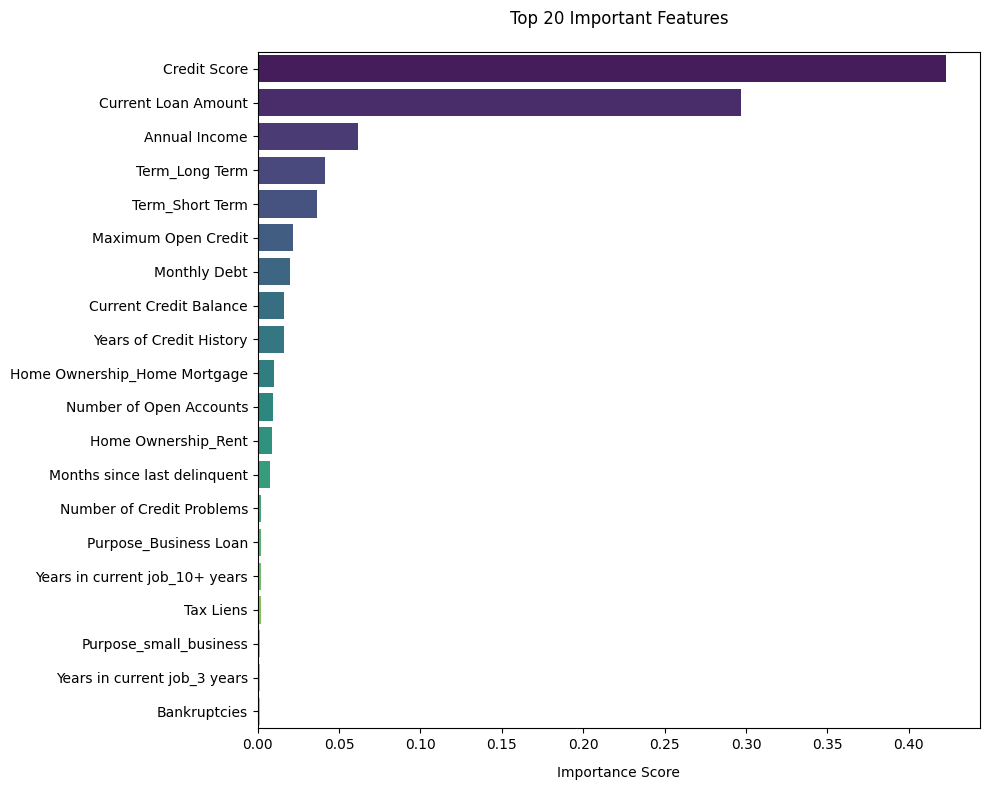

In [9]:
# Feature importance analysis (optimized version)
# Get feature names
cat_encoder = rf_pipeline.named_steps['preprocessor'].named_transformers_['cat']
cat_features = cat_encoder.get_feature_names_out(categorical_cols)
all_features = numerical_cols + list(cat_features)

# Extract and sort importances
importances = rf_pipeline.named_steps['classifier'].feature_importances_
importance_df = pd.DataFrame({'Feature': all_features, 'Importance': importances})
importance_df = importance_df.sort_values('Importance', ascending=False).head(20)

# Plot with corrected syntax
plt.figure(figsize=(10, 8))
sns.barplot(
    data=importance_df,
    x='Importance',
    y='Feature',
    hue='Feature',  
    palette='viridis',
    legend=False,   
    dodge=False    
)
plt.title('Top 20 Important Features', pad=20)
plt.xlabel('Importance Score', labelpad=10)
plt.ylabel('')
plt.tight_layout()
plt.show()

In [10]:
# Save outputs
# Save model
joblib.dump(rf_pipeline, 'loan_status_rf_model.pkl')

# Save predictions with probabilities
results_df = X_test.copy()
results_df['Actual'] = y_test
results_df['Predicted'] = y_pred
results_df['Probability_Charged_Off'] = y_proba
results_df.to_csv('model_predictions.csv', index=False)

print("\nOutputs saved:")
print("- Model: loan_status_rf_model.pkl")
print("- Predictions: model_predictions.csv")


Outputs saved:
- Model: loan_status_rf_model.pkl
- Predictions: model_predictions.csv
